In [1]:
PATH_TO_EXPERIMENTS_FOLDER = 'LSTM/results'

### Necessary helper function

In [2]:
normal_classes = {"yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"}
to_be_subsampled = {
    "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "bed",
    "bird", "cat", "dog", "happy", "house", "marvin", "sheila", "tree", "wow", "backward",
    "forward", "follow", "learn", "visual",
}

from datasets import load_dataset, concatenate_datasets
from torch.utils.data import DataLoader
from math import ceil
import numpy as np
import librosa
import torch

def extract_fields(example):
    x = example["audio"]["array"]
    return {
        "label": example["label"],
        "array": np.pad(x, (0, 16000 - len(x)), constant_values=0),
    }


def swap_to_unknown(examples):
    examples["label"] = [10] * len(examples["label"])
    return examples


def swap_to_silence(examples):
    examples["label"] = [11] * len(examples["label"])
    return examples


def cut_audio(example):

    if len(example["audio"]["array"]) > 16000:
        example["audio"]["array"] = example["audio"]["array"][:16000]

    return example


def swap_labels_for_data_split(data):
    id2label_org = data.features["label"].int2str    
    normal = data.filter(lambda x: id2label_org(x["label"]) in normal_classes)

    class_size = ceil(len(normal) / len(normal_classes))
    to_subsample = data.filter(lambda x: id2label_org(x["label"]) in to_be_subsampled)
    silence = data.filter(lambda x: id2label_org(x["label"]) == "_silence_")

    silence = silence.map(cut_audio)
    to_subsample = to_subsample.map(swap_to_unknown, batched=True)

    if len(to_subsample) > class_size:
        to_subsample = to_subsample.shuffle(seed=42).select(range(class_size))

    to_subsample = to_subsample.map(swap_to_unknown, batched=True)
    silence = silence.map(swap_to_silence, batched=True)
    results = concatenate_datasets([normal, to_subsample, silence])
    return results

def calculate_accuracy(preds, y):
    preds = torch.nn.functional.softmax(preds, dim=1)
    preds = torch.argmax(preds, dim=1)
    return (torch.sum(preds == y) / len(y)).item()

def compute_mfcc(data, sample_rate=16000, n_mfcc=12):
    # Extract MFCC features
    # https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html
    mfcc = librosa.feature.mfcc(
        y=data,
        sr=sample_rate,
        n_mfcc=n_mfcc,  # How many mfcc features to use? 12 at most.
        # https://dsp.stackexchange.com/questions/28898/mfcc-significance-of-number-of-features
    )
    return mfcc

def get_test_data():
    test = load_dataset(
        "speech_commands", "v0.02", split='test', cache_dir='tmp_here'
    )
    
    test = swap_labels_for_data_split(test)
    
    test = test.map(
        extract_fields, remove_columns=["file", "audio", "speaker_id", "utterance_id"]
    )
    
    return test.with_format("torch")

In [3]:
test = get_test_data()
test_loader = DataLoader(test, batch_size=256)

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

LABELS = ["yes", "no", "up", "down",
          "left", 'right', 'on', 'off', 
          'stop', 'go', 'unknown', 'silence']

def save_confusion_matrix(true_labels, predicted_labels, acc, filename):
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, cmap="Blues")
    plt.xticks(rotation=45)
    plt.title(f"Accuracy: {acc:.3f}")
    plt.savefig(filename)

In [5]:
from LSTM.models import RNNModel, LSTMModel, GRUModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODELS = {
    'rnn': RNNModel,
    'lstm': LSTMModel,
    'gru': GRUModel,
}

In [6]:
from tqdm.auto import tqdm

def evaluate_model(model, test_loader):
    model.eval()
    test_accuracy = 0.0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in tqdm(test_loader):
            x = batch["array"]
            x = (
                torch.Tensor(compute_mfcc(np.array(x), 16_000))
                .permute(0, 2, 1)
                .to(device)
            )
            y = batch["label"].to(device)
            y_pred = model(x.float())
            test_accuracy += calculate_accuracy(y_pred, y)
            predictions.append(y_pred)
            true_labels.append(y)
    test_accuracy = test_accuracy / len(test_loader)

    predictions = torch.cat(predictions)
    true_labels = torch.cat(true_labels)
    predictions = torch.argmax(predictions, dim=1)
    true_labels = true_labels.cpu().numpy()
    predictions = predictions.cpu().numpy()
    
    return test_accuracy, predictions, true_labels

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

/mnt/evafs/groups/ganzha_23/mgalkowski/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.15 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: 'LSTM/results/GRUModel__NUM_LAY_1_HID_32_SEED_1/test_results.json'

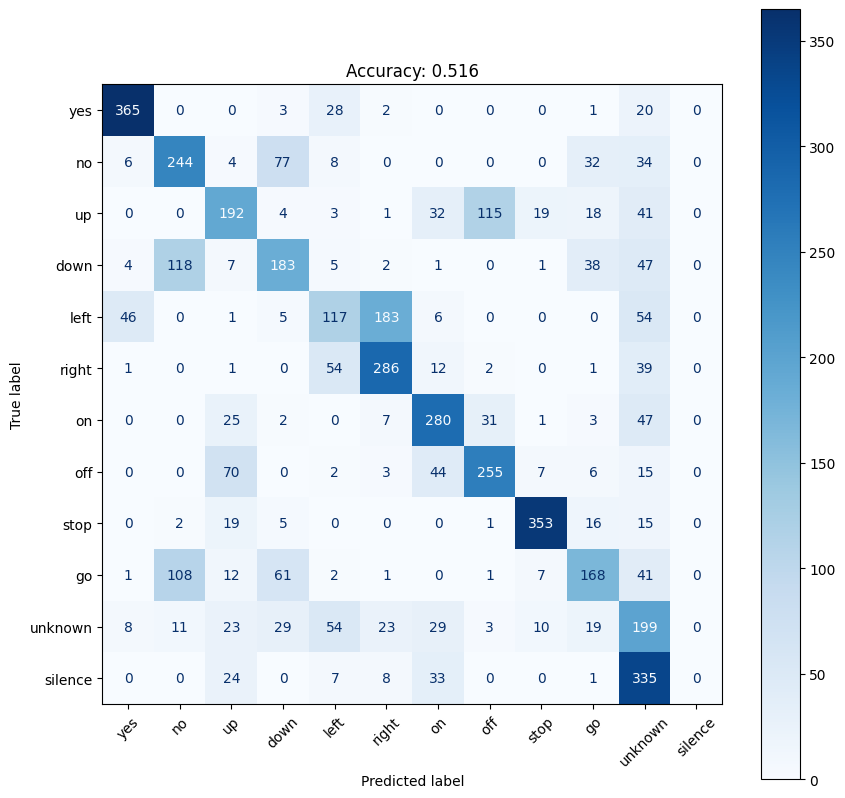

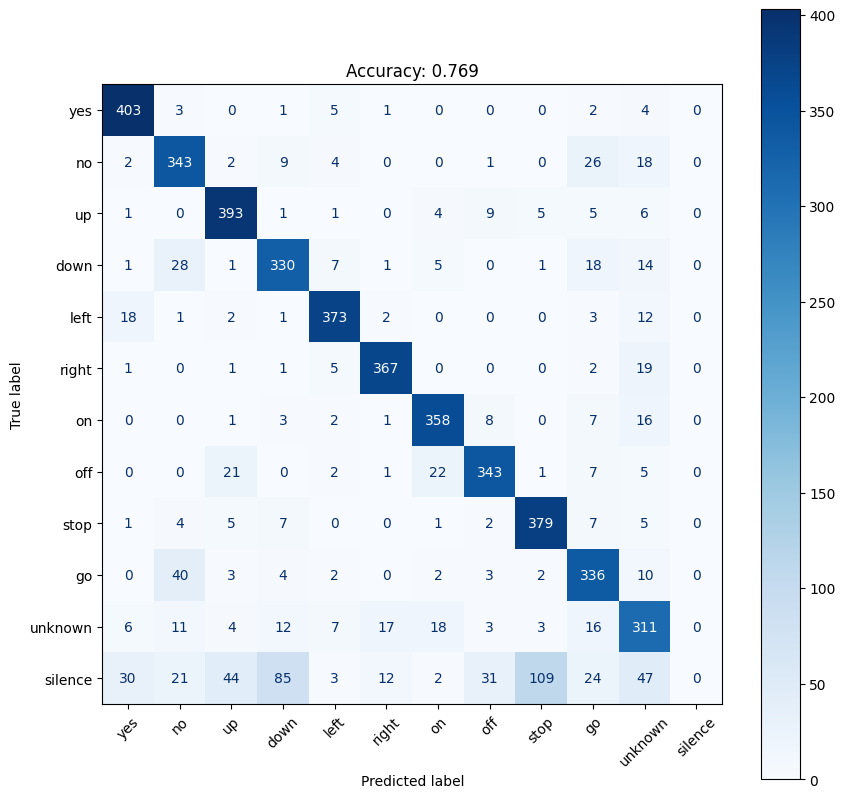

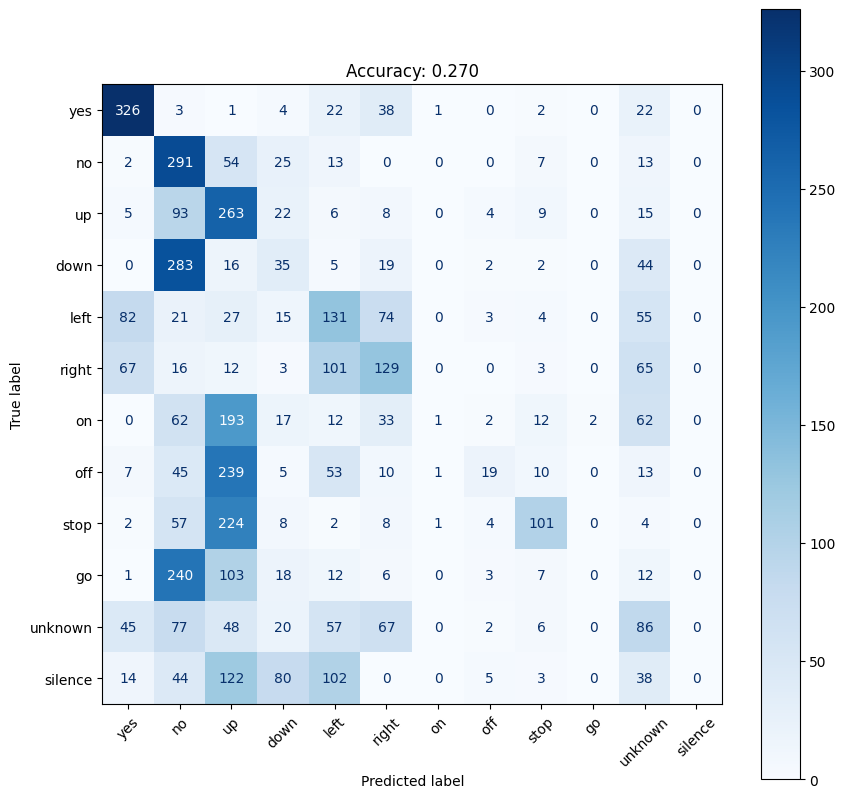

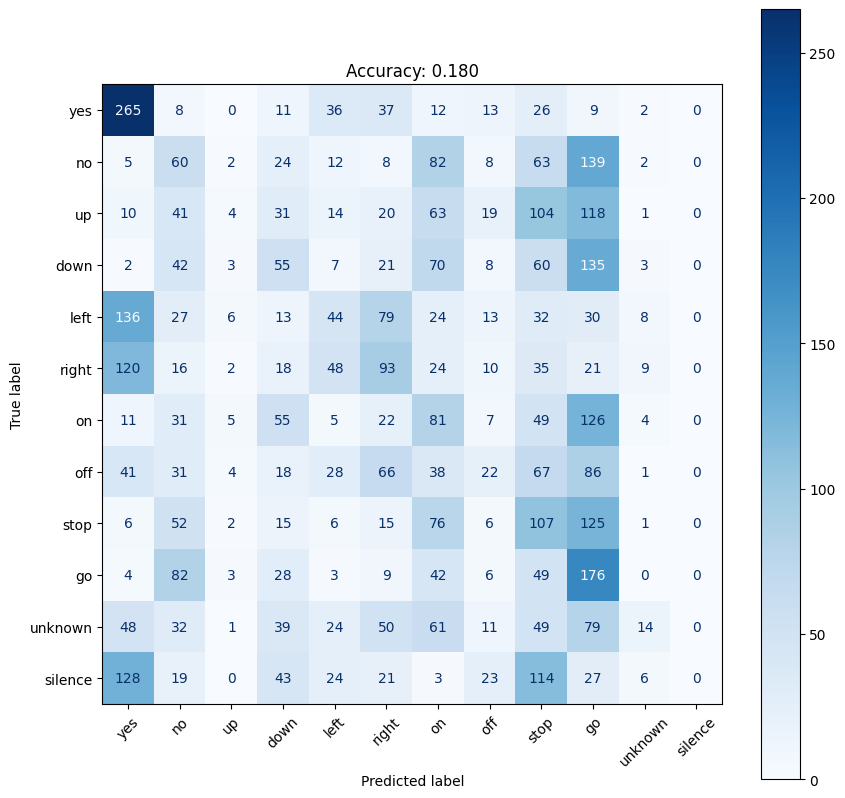

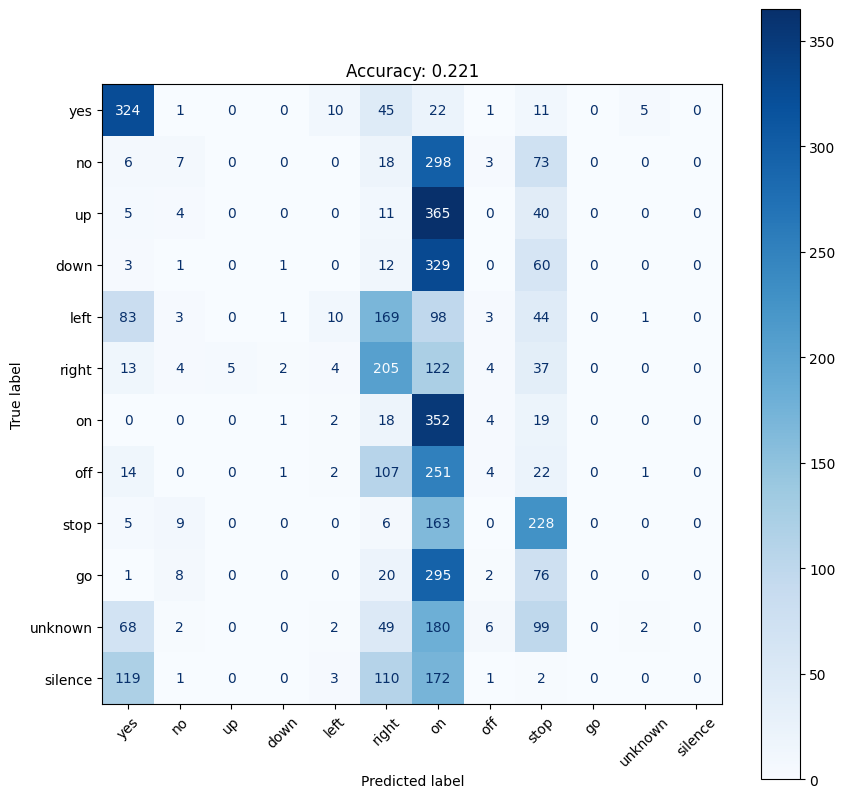

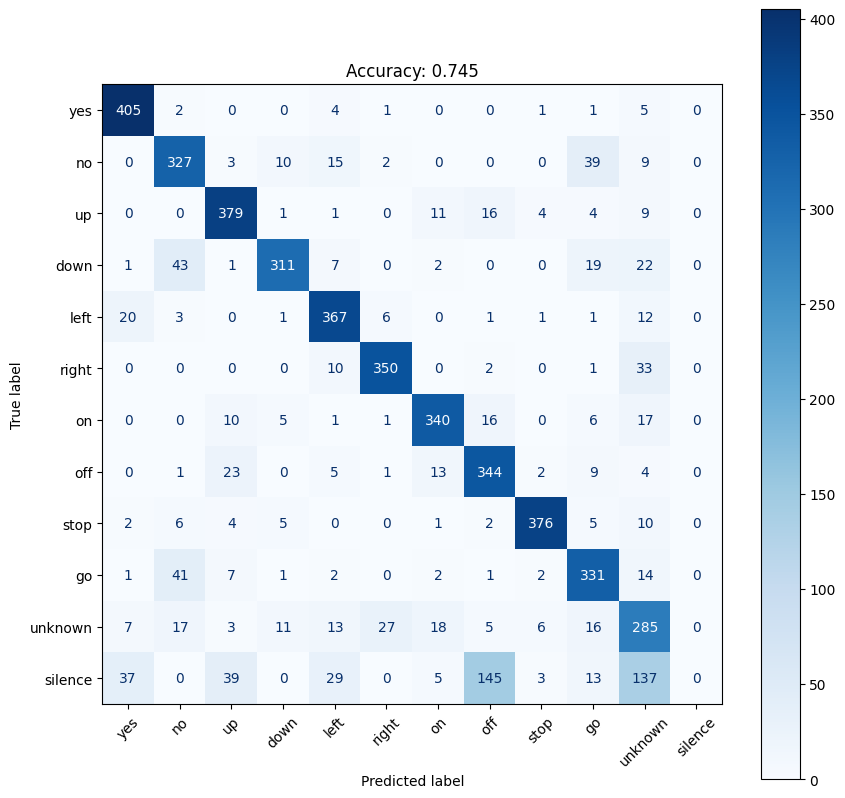

In [7]:
import json
import torch
import os

for folder in tqdm(os.listdir(PATH_TO_EXPERIMENTS_FOLDER)):
    path = os.path.join(PATH_TO_EXPERIMENTS_FOLDER, folder)
    
    with open(path + '/test_results.json', 'r') as f:
        test_results = json.load(f)['test_accuracy']
    with open(path + '/config.json', 'r') as f:
        config = json.load(f)
    
    torch.cuda.empty_cache()
    weights = torch.load(path + '/best_model.pth', map_location=device)
    
    model = MODELS[config['model']](12, hidden_size=config['hidden_size'], num_layers=config['num_layers'], output_size=12)
    model.load_state_dict(weights)
    model.to(device)

    test_acc, predictions, true_labels = evaluate_model(model, test_loader)
    save_confusion_matrix(true_labels, predictions, test_acc, path + '/confussion_matrix.png')